# Aggregate MAP and NIRS data

Store all data in a csv file. Examine graph to identify erroneous values.

Simo Mäkelä  
Helsinki Metropolia University of Applied Sciences  
4.10.2020

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import zoll
from utils import nirs
from utils import misc
from utils.autoscale import autoscale

In [2]:
# parameters
case_id = 1

In [3]:
case_str = str(case_id).zfill(5)
zoll_filename = 'zoll' + case_str + '.json'
nirs_filename = 'nirs' + case_str + '.csv'
json = zoll.LoadJSON("data/" + zoll_filename)

In [4]:
# load pulse waveform from channel 1
bp_df, bp_samplerate = zoll.LoadWaveform(json, hide_starttime=True, discard_by_status=False, channel=1)

Channel 1: CO2 kPa, Waveform
WaveType:  48
Duration:         4050.12 s
Total samples:     506265      Discarded:       0
Sample rate:          125 1/s  Sample time:  8000 μs
Min:                 -227      Max:           339



In [5]:
# for MAP
def ComputeAverage(waveform, window, samplerate, win_type=None):
    win = window * samplerate
    return waveform.rolling(win, win_type=win_type).mean()

bp_df.rename(columns={'BadSignal': 'Bad_MAP_auto'}, inplace=True)

In [6]:
# compute MAP using a 10 second sliding average
bp_df['MAP'] = ComputeAverage(bp_df['Waveform'], 10, bp_samplerate)

In [7]:
# merge with NIRS (rSO2) data
nirs_df = nirs.LoadCSV("data/" + nirs_filename,
                       discard_by_status=False)

df = pd.merge_asof(nirs_df[['rSO2', 'Mark', 'Bad_rSO2_auto']], bp_df[['MAP', 'Bad_MAP_auto']], on='Time', direction='nearest')

misc.NormalizeTime(df)
t_start, t_end = misc.CreateElapsedTimeColumn(df) # for colormap

df['T'] = df['Time'].apply(lambda x: x.strftime('%H:%M:%S'))
df['Time'] = df['T']


In [8]:
df[['Time', 'MAP', 'Bad_MAP_auto', 'rSO2', 'Mark', 'Bad_rSO2_auto', 'Elapsed']].to_csv('output/' + case_str + '_2.csv', na_rep='-', index_label='id')

In [9]:
df['Time'] = pd.to_datetime(df['Time'])
misc.NormalizeTime(df)
df.set_index('Time', inplace=True)

In [10]:
map_ranges = misc.GetRanges(df, 'Bad_MAP_auto')
nirs_ranges = misc.GetRanges(df, 'Bad_rSO2_auto')

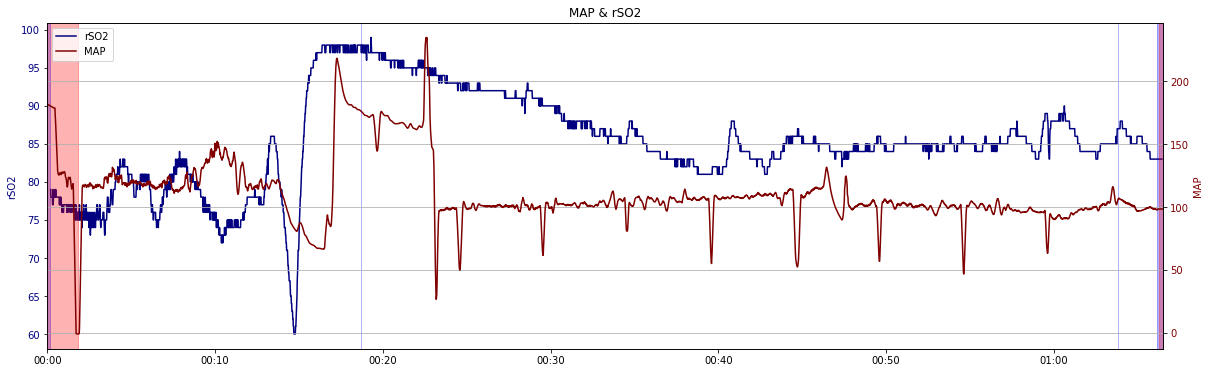

In [11]:
fig, ax1 = plt.subplots(figsize=(20,6))
ax1.set_ylabel('rSO2', color='navy')
line1 = ax1.plot(df.index, df['rSO2'], color='navy', label='rSO2')
ax1.tick_params(axis='y', labelcolor='navy')
ax2 = ax1.twinx()
ax2.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
ax2.set_ylabel('MAP', color='maroon')
line2 = ax2.plot(df.index, df['MAP'], color='maroon', label='MAP')
ax2.tick_params(axis='y', labelcolor='maroon')
lines = line1 + line2
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc='upper left')
ax2.grid()
plt.title('MAP & rSO2')
for r in nirs_ranges:
    ax1.axvspan(r[0], r[1], alpha=0.3, color='blue')
for r in map_ranges:
    ax2.axvspan(r[0], r[1], alpha=0.3, color='red')
plt.autoscale(enable=True, axis="x", tight=True)
plt.show()